Training Enhanced FNO with Traction Forces and Boundary Conditions...
Loading enhanced dataset...
E-field shape: (1, 33, 65, 1)
Traction X shape: (1, 33, 65, 1)
Traction Y shape: (1, 33, 65, 1)
Output shape: (1, 33, 65, 2)
Boundary conditions: {'type': 'Dirichlet', 'applied_on': 'left boundary (x=0)', 'value': (0.0, 0.0)}
Enhanced model initialized with 50,562,946 parameters
Epoch 0: Loss = 0.997670
Epoch 10: Loss = 0.763478
Epoch 20: Loss = 0.494228
Epoch 30: Loss = 0.351285
Epoch 40: Loss = 0.315375
Epoch 50: Loss = 0.192475
Epoch 60: Loss = 0.166915
Epoch 70: Loss = 0.140001
Epoch 80: Loss = 0.131437
Epoch 90: Loss = 0.117925
Epoch 100: Loss = 0.112850
Epoch 110: Loss = 0.107716
Epoch 120: Loss = 0.095436
Epoch 130: Loss = 0.089788
Epoch 140: Loss = 0.092725
Enhanced FNO elasticity results plot saved!


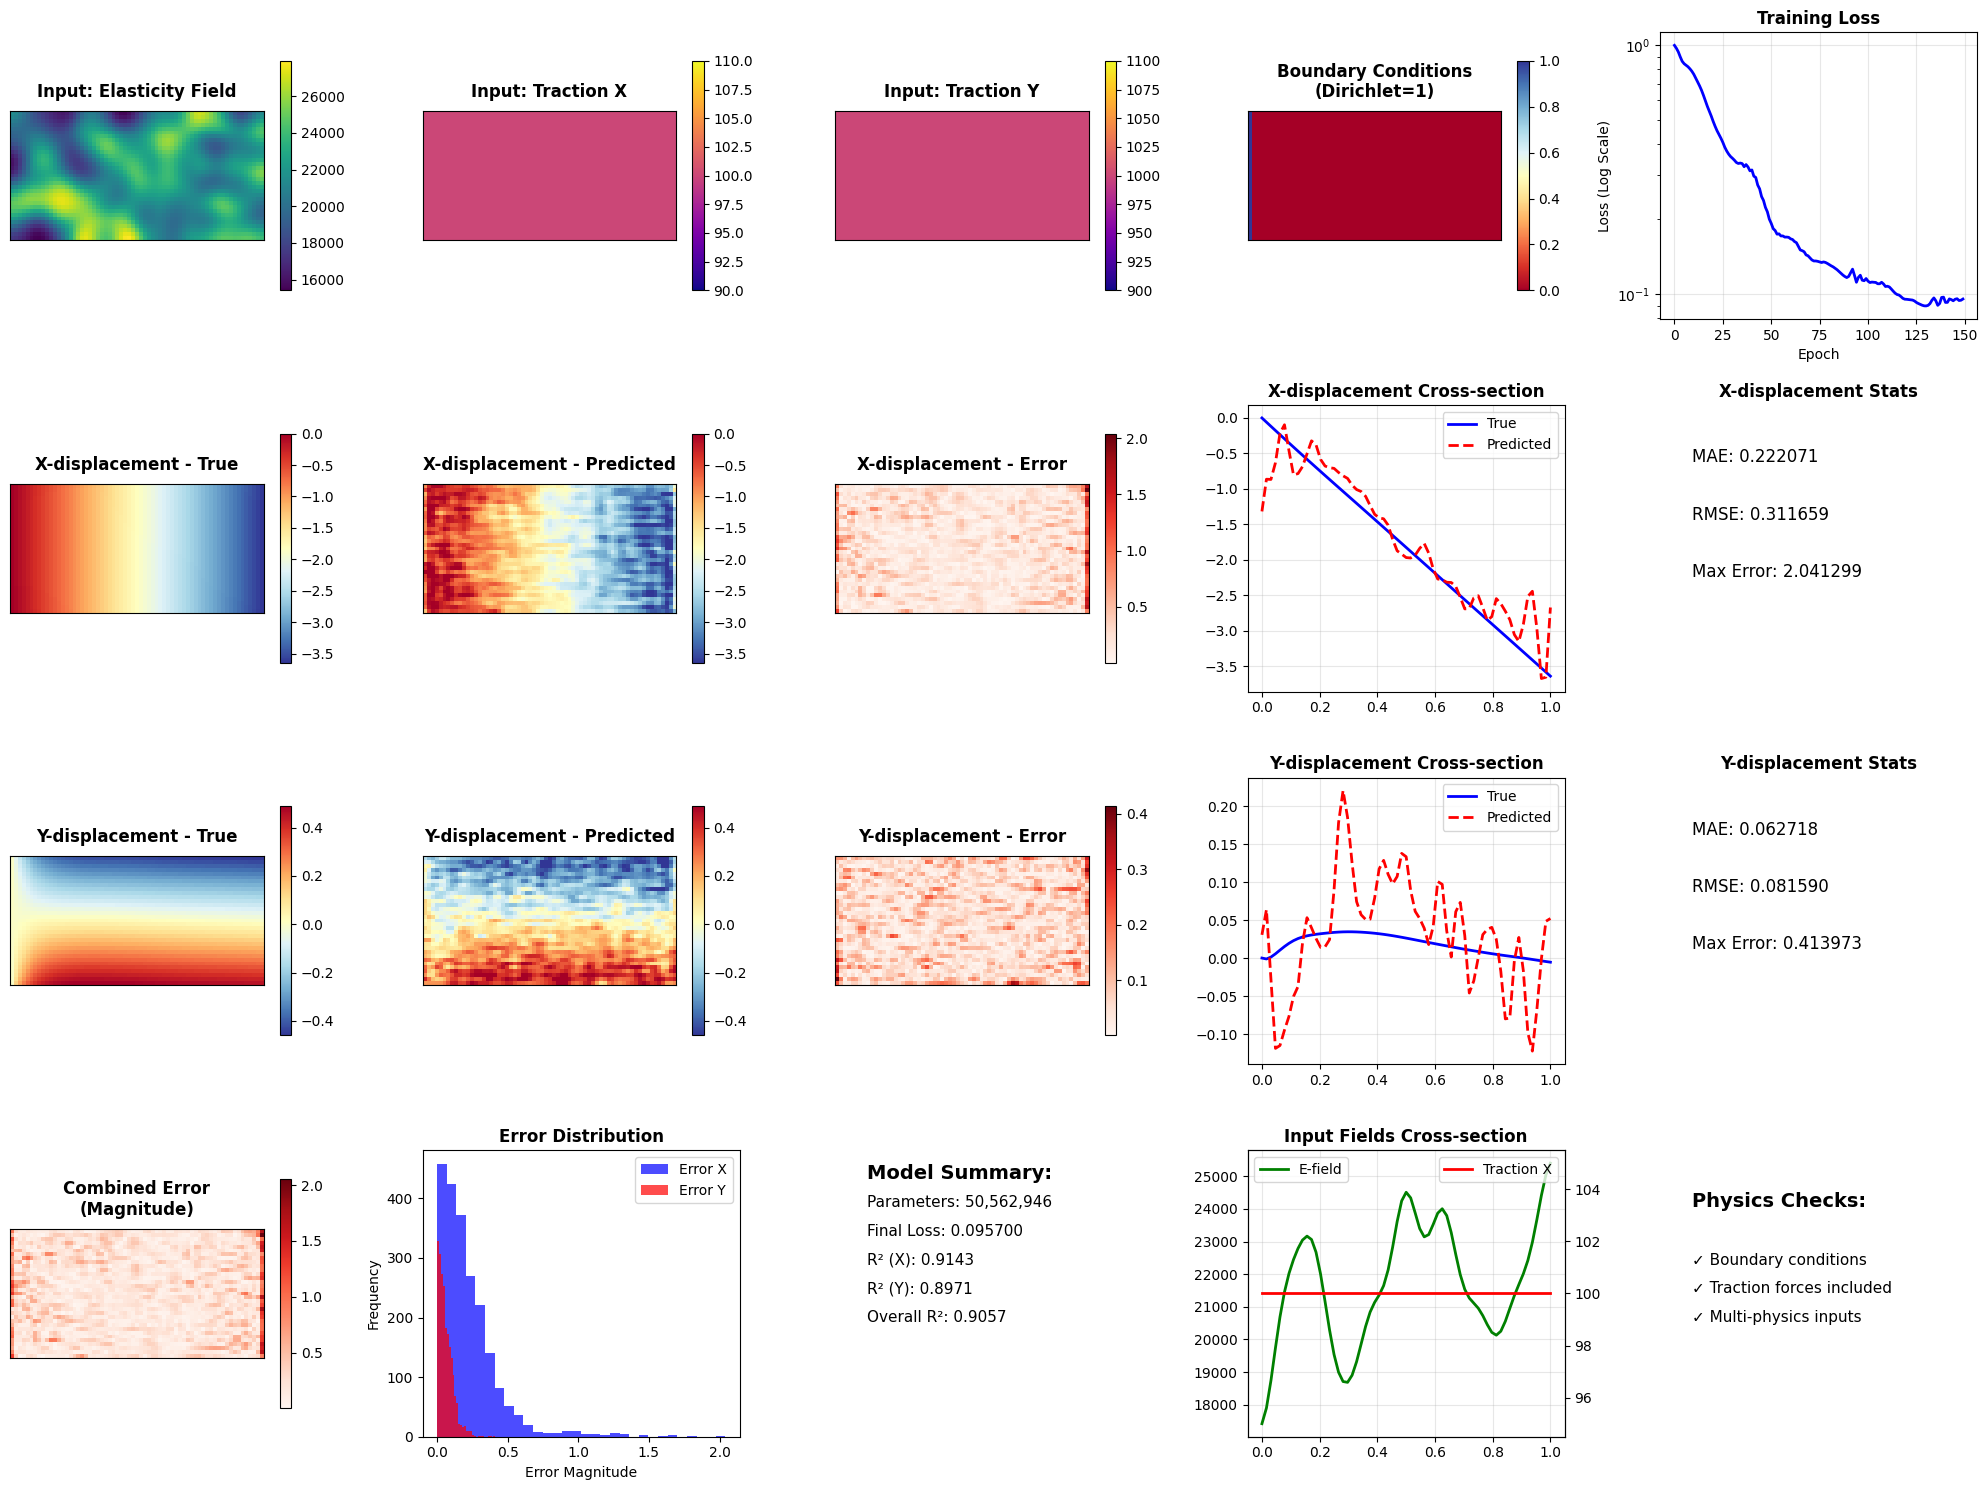

Enhanced FNO training and analysis completed successfully!


In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
import numpy as np
from functools import partial
import optax

class SpectralConv2d(nn.Module):
    """Spectral convolution layer for FNO"""
    out_channels: int
    modes1: int  # Number of Fourier modes in first spatial dimension
    modes2: int  # Number of Fourier modes in second spatial dimension

    @nn.compact
    def __call__(self, x):
        batch_size, height, width, in_channels = x.shape

        # Initialize learnable Fourier weights
        weights1 = self.param('weights1',
                             nn.initializers.normal(stddev=0.02),
                             (in_channels, self.out_channels, self.modes1, self.modes2),
                             jnp.complex64)
        weights2 = self.param('weights2',
                             nn.initializers.normal(stddev=0.02),
                             (in_channels, self.out_channels, self.modes1, self.modes2),
                             jnp.complex64)

        # Compute 2D FFT
        x_ft = jnp.fft.rfft2(x, axes=(1, 2))

        # Initialize output in Fourier domain
        out_ft = jnp.zeros((batch_size, height, width//2 + 1, self.out_channels), dtype=jnp.complex64)

        # Multiply relevant Fourier modes
        x_lower = x_ft[:, :self.modes1, :self.modes2, :]
        out_lower = jnp.einsum('bhwi,iohw->bhwo', x_lower, weights1)
        out_ft = out_ft.at[:, :self.modes1, :self.modes2, :].set(out_lower)

        if self.modes1 < height:
            x_upper = x_ft[:, -self.modes1:, :self.modes2, :]
            out_upper = jnp.einsum('bhwi,iohw->bhwo', x_upper, weights2)
            out_ft = out_ft.at[:, -self.modes1:, :self.modes2, :].set(out_upper)

        # Inverse 2D FFT
        x = jnp.fft.irfft2(out_ft, s=(height, width), axes=(1, 2))

        return x

class FourierStage(nn.Module):
    """Single Fourier stage combining spectral and local convolutions"""
    width: int
    modes1: int
    modes2: int
    activation: Callable = nn.gelu

    @nn.compact
    def __call__(self, x):
        # Spectral convolution branch
        x_fourier = SpectralConv2d(self.width, self.modes1, self.modes2)(x)

        # Local convolution branch (skip connection)
        x_local = nn.Conv(self.width, kernel_size=(1, 1))(x)

        # Combine branches and apply activation
        x = self.activation(x_fourier + x_local)

        return x

class BoundaryConditionEncoder(nn.Module):
    """Encode boundary conditions as spatial fields"""

    @nn.compact
    def __call__(self, height, width, bc_info, tolerance=1e-6):
        """
        Create boundary condition masks
        bc_info: dictionary with boundary condition information
        """
        # Create coordinate grids
        x = jnp.linspace(0, 1, width)
        y = jnp.linspace(0, 1, height)
        Y, X = jnp.meshgrid(y, x, indexing='ij')

        # Initialize boundary condition fields
        bc_mask = jnp.zeros((height, width, 1))  # 1 for Dirichlet, 0 for free

        # Mark Dirichlet boundary (left side, x=0) based on your bc_info
        dirichlet_mask = (X <= tolerance).astype(jnp.float32)
        bc_mask = bc_mask.at[:, :, 0].set(dirichlet_mask)

        return bc_mask

class FNO2dElasticity(nn.Module):
    """2D Fourier Neural Operator for Elasticity Problems"""
    modes1: int = 12
    modes2: int = 12
    width: int = 64
    depth: int = 4
    activation: Callable = nn.gelu

    @nn.compact
    def __call__(self, inputs_dict):
        """
        inputs_dict should contain:
        - 'E_field': elasticity field
        - 'traction_x': x-component of traction forces
        - 'traction_y': y-component of traction forces
        - 'bc_info': boundary condition information
        """
        # Extract individual fields
        E_field = inputs_dict['E_field']  # Shape: (batch, height, width, 1)
        traction_x = inputs_dict['traction_x']  # Shape: (batch, height, width, 1)
        traction_y = inputs_dict['traction_y']  # Shape: (batch, height, width, 1)
        bc_info = inputs_dict.get('bc_info', {})

        batch_size, height, width, _ = E_field.shape

        # Create boundary condition encoding
        bc_encoder = BoundaryConditionEncoder()
        bc_mask = bc_encoder(height, width, bc_info)
        bc_mask = jnp.broadcast_to(bc_mask[None, :, :, :], (batch_size, height, width, 1))

        # Concatenate all input fields
        x = jnp.concatenate([E_field, traction_x, traction_y, bc_mask], axis=-1)
        # Current shape: (batch, height, width, 4)

        # Lift to higher dimensional space
        x = nn.Conv(self.width, kernel_size=(1, 1), name='lift')(x)

        # Add coordinate information
        grid_x = jnp.linspace(0, 1, width)
        grid_y = jnp.linspace(0, 1, height)
        grid_y, grid_x = jnp.meshgrid(grid_y, grid_x, indexing='ij')

        # Add batch dimension and channel dimension
        grid_x = jnp.broadcast_to(grid_x[None, :, :, None], (batch_size, height, width, 1))
        grid_y = jnp.broadcast_to(grid_y[None, :, :, None], (batch_size, height, width, 1))

        x = jnp.concatenate([x, grid_x, grid_y], axis=-1)

        # Apply Fourier stages
        for i in range(self.depth):
            x = FourierStage(self.width, self.modes1, self.modes2, self.activation,
                           name=f'fourier_stage_{i}')(x)

        # Project to output dimension (2 channels for x and y displacement)
        x = nn.Conv(2, kernel_size=(1, 1), name='project')(x)

        return x

def create_enhanced_data_loaders(dataset_path, batch_size=1, train_split=0.8):
    """Create enhanced data loaders including traction and boundary conditions"""
    # Load data with pickle support for complex objects like dictionaries
    data = np.load(dataset_path, allow_pickle=True)

    # Extract all fields
    E_field = data['E_field']  # Shape: (Ny, Nx)
    disp_x = data['displacement_x']  # Shape: (Ny, Nx)
    disp_y = data['displacement_y']  # Shape: (Ny, Nx)

    # Extract traction forces - handle different possible formats
    if 'applied_traction_x' in data:
        traction_x_raw = data['applied_traction_x']
        traction_y_raw = data['applied_traction_y']

        # Handle case where traction might be a single value or 0-dimensional array
        if np.isscalar(traction_x_raw) or traction_x_raw.ndim == 0:
            traction_x = np.full_like(E_field, float(traction_x_raw))
        elif traction_x_raw.shape != E_field.shape:
            # If shapes don't match, create uniform field with the value
            traction_x = np.full_like(E_field, float(traction_x_raw.flatten()[0]))
        else:
            traction_x = traction_x_raw

        if np.isscalar(traction_y_raw) or traction_y_raw.ndim == 0:
            traction_y = np.full_like(E_field, float(traction_y_raw))
        elif traction_y_raw.shape != E_field.shape:
            # If shapes don't match, create uniform field with the value
            traction_y = np.full_like(E_field, float(traction_y_raw.flatten()[0]))
        else:
            traction_y = traction_y_raw
    else:
        # Fallback to uniform traction if not in dataset
        traction_x = np.full_like(E_field, 1e2)
        traction_y = np.full_like(E_field, 1e3)

    # Extract boundary condition info - handle different formats safely
    try:
        if 'boundary_conditions' in data:
            bc_data = data['boundary_conditions']
            # If it's a numpy array containing an object, extract it
            if hasattr(bc_data, 'item'):
                bc_info = bc_data.item() if bc_data.size == 1 else bc_data
            else:
                bc_info = bc_data
        else:
            bc_info = {}
    except Exception as e:
        print(f"Warning: Could not load boundary conditions: {e}")
        bc_info = {}

    # Prepare inputs as dictionary
    inputs = {
        'E_field': E_field[None, :, :, None],  # Shape: (1, Ny, Nx, 1)
        'traction_x': traction_x[None, :, :, None],  # Shape: (1, Ny, Nx, 1)
        'traction_y': traction_y[None, :, :, None],  # Shape: (1, Ny, Nx, 1)
        'bc_info': bc_info
    }

    # Prepare output (displacement fields stacked)
    outputs = jnp.stack([disp_x, disp_y], axis=-1)[None, :, :]  # Shape: (1, Ny, Nx, 2)

    print(f"E-field shape: {inputs['E_field'].shape}")
    print(f"Traction X shape: {inputs['traction_x'].shape}")
    print(f"Traction Y shape: {inputs['traction_y'].shape}")
    print(f"Output shape: {outputs.shape}")
    print(f"Boundary conditions: {bc_info}")

    # Normalize data
    # Normalize E-field
    e_mean = jnp.mean(inputs['E_field'])
    e_std = jnp.std(inputs['E_field'])
    inputs['E_field'] = (inputs['E_field'] - e_mean) / (e_std + 1e-8)

    # Normalize traction forces
    tx_mean = jnp.mean(inputs['traction_x'])
    tx_std = jnp.std(inputs['traction_x'])
    inputs['traction_x'] = (inputs['traction_x'] - tx_mean) / (tx_std + 1e-8)

    ty_mean = jnp.mean(inputs['traction_y'])
    ty_std = jnp.std(inputs['traction_y'])
    inputs['traction_y'] = (inputs['traction_y'] - ty_mean) / (ty_std + 1e-8)

    # Normalize outputs
    output_mean = jnp.mean(outputs, axis=(0, 1, 2), keepdims=True)
    output_std = jnp.std(outputs, axis=(0, 1, 2), keepdims=True)
    outputs_norm = (outputs - output_mean) / (output_std + 1e-8)

    return {
        'inputs': inputs,
        'outputs': outputs_norm,
        'input_stats': {
            'e_mean': e_mean, 'e_std': e_std,
            'tx_mean': tx_mean, 'tx_std': tx_std,
            'ty_mean': ty_mean, 'ty_std': ty_std
        },
        'output_stats': {'mean': output_mean, 'std': output_std}
    }

def enhanced_train_step(params, opt_state, batch, optimizer, model):
    """Enhanced training step for elasticity FNO"""
    def loss_fn(params):
        pred = model.apply(params, batch['inputs'])

        # Main displacement loss
        mse_loss = jnp.mean((pred - batch['outputs'])**2)

        # Optional: Add physics-based regularization
        # You could add strain energy consistency, equilibrium constraints, etc.

        return mse_loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

def train_enhanced_fno(dataset_path, config):
    """Train enhanced FNO with traction forces and boundary conditions"""

    print("Loading enhanced dataset...")
    data_dict = create_enhanced_data_loaders(dataset_path, config['batch_size'])

    # Initialize enhanced model
    model = FNO2dElasticity(
        modes1=config['modes1'],
        modes2=config['modes2'],
        width=config['width'],
        depth=config['depth']
    )

    # Initialize parameters with dummy input dictionary
    rng = jax.random.PRNGKey(42)
    dummy_inputs = {
        'E_field': jnp.ones_like(data_dict['inputs']['E_field']),
        'traction_x': jnp.ones_like(data_dict['inputs']['traction_x']),
        'traction_y': jnp.ones_like(data_dict['inputs']['traction_y']),
        'bc_info': data_dict['inputs']['bc_info']
    }
    params = model.init(rng, dummy_inputs)

    total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
    print(f"Enhanced model initialized with {total_params:,} parameters")

    # Initialize optimizer
    optimizer = optax.adam(config['learning_rate'])
    opt_state = optimizer.init(params)

    # Training loop
    losses = []
    batch = {'inputs': data_dict['inputs'], 'outputs': data_dict['outputs']}

    for epoch in range(config['epochs']):
        params, opt_state, loss = enhanced_train_step(params, opt_state, batch, optimizer, model)
        losses.append(float(loss))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f}")

    return {
        'params': params,
        'losses': losses,
        'model': model,
        'data_stats': {
            'input_stats': data_dict['input_stats'],
            'output_stats': data_dict['output_stats']
        },
        'data_dict': data_dict
    }

def plot_enhanced_results(results, dataset_path, save_figures=True):
    """Plot results for enhanced FNO model"""
    import matplotlib.pyplot as plt

    # Extract data
    model = results['model']
    params = results['params']
    data_dict = results['data_dict']
    losses = results['losses']

    # Load original data for comparison
    data = np.load(dataset_path, allow_pickle=True)
    E_field = data['E_field']
    true_disp_x = data['displacement_x']
    true_disp_y = data['displacement_y']

    # Handle traction data properly for plotting
    if 'applied_traction_x' in data:
        traction_x_raw = data['applied_traction_x']
        traction_y_raw = data['applied_traction_y']

        # Convert to proper 2D arrays for plotting
        if np.isscalar(traction_x_raw) or traction_x_raw.ndim == 0:
            traction_x = np.full_like(E_field, float(traction_x_raw))
        elif traction_x_raw.shape != E_field.shape:
            traction_x = np.full_like(E_field, float(traction_x_raw.flatten()[0]))
        else:
            traction_x = traction_x_raw

        if np.isscalar(traction_y_raw) or traction_y_raw.ndim == 0:
            traction_y = np.full_like(E_field, float(traction_y_raw))
        elif traction_y_raw.shape != E_field.shape:
            traction_y = np.full_like(E_field, float(traction_y_raw.flatten()[0]))
        else:
            traction_y = traction_y_raw
    else:
        traction_x = np.full_like(E_field, 1e2)
        traction_y = np.full_like(E_field, 1e3)

    # Get model predictions
    prediction = model.apply(params, data_dict['inputs'])

    # Denormalize predictions
    output_stats = results['data_stats']['output_stats']
    prediction_denorm = prediction * output_stats['std'] + output_stats['mean']

    # Extract predicted displacement components
    pred_disp_x = prediction_denorm[0, :, :, 0]
    pred_disp_y = prediction_denorm[0, :, :, 1]

    # Calculate absolute errors
    error_x = np.abs(true_disp_x - pred_disp_x)
    error_y = np.abs(true_disp_y - pred_disp_y)

    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 15))

    def format_subplot(ax, title, add_colorbar=True, im=None):
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.set_xticks([])
        ax.set_yticks([])
        if add_colorbar and im is not None:
            cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
            cbar.ax.tick_params(labelsize=10)
        return ax

    # Row 1: Input fields
    # Elasticity field
    ax1 = plt.subplot(4, 5, 1)
    im1 = ax1.imshow(E_field, cmap='viridis', aspect='equal', origin='lower')
    format_subplot(ax1, 'Input: Elasticity Field', True, im1)

    # Traction X
    ax2 = plt.subplot(4, 5, 2)
    im2 = ax2.imshow(traction_x, cmap='plasma', aspect='equal', origin='lower')
    format_subplot(ax2, 'Input: Traction X', True, im2)

    # Traction Y
    ax3 = plt.subplot(4, 5, 3)
    im3 = ax3.imshow(traction_y, cmap='plasma', aspect='equal', origin='lower')
    format_subplot(ax3, 'Input: Traction Y', True, im3)

    # Boundary conditions visualization
    ax4 = plt.subplot(4, 5, 4)
    # Create BC mask for visualization
    bc_vis = np.zeros_like(E_field)
    bc_vis[:, 0] = 1  # Dirichlet BC on left boundary
    im4 = ax4.imshow(bc_vis, cmap='RdYlBu', aspect='equal', origin='lower')
    format_subplot(ax4, 'Boundary Conditions\n(Dirichlet=1)', True, im4)

    # Training loss
    ax5 = plt.subplot(4, 5, 5)
    ax5.semilogy(losses, 'b-', linewidth=2)
    ax5.set_title('Training Loss', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss (Log Scale)')
    ax5.grid(True, alpha=0.3)

    # Row 2: X-displacement results
    # True X displacement
    ax6 = plt.subplot(4, 5, 6)
    im6 = ax6.imshow(true_disp_x, cmap='RdYlBu_r', aspect='equal', origin='lower')
    format_subplot(ax6, 'X-displacement - True', True, im6)

    # Predicted X displacement
    ax7 = plt.subplot(4, 5, 7)
    im7 = ax7.imshow(pred_disp_x, cmap='RdYlBu_r', aspect='equal', origin='lower',
                     vmin=np.min(true_disp_x), vmax=np.max(true_disp_x))
    format_subplot(ax7, 'X-displacement - Predicted', True, im7)

    # X displacement error
    ax8 = plt.subplot(4, 5, 8)
    im8 = ax8.imshow(error_x, cmap='Reds', aspect='equal', origin='lower')
    format_subplot(ax8, 'X-displacement - Error', True, im8)

    # X displacement cross-section
    ax9 = plt.subplot(4, 5, 9)
    mid_row = true_disp_x.shape[0] // 2
    x_pos = np.linspace(0, 1, true_disp_x.shape[1])
    ax9.plot(x_pos, true_disp_x[mid_row, :], 'b-', label='True', linewidth=2)
    ax9.plot(x_pos, pred_disp_x[mid_row, :], 'r--', label='Predicted', linewidth=2)
    ax9.set_title('X-displacement Cross-section', fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    # X displacement statistics
    ax10 = plt.subplot(4, 5, 10)
    ax10.axis('off')
    mae_x = np.mean(error_x)
    rmse_x = np.sqrt(np.mean(error_x**2))
    max_error_x = np.max(error_x)
    ax10.text(0.1, 0.8, f'MAE: {mae_x:.6f}', fontsize=12, transform=ax10.transAxes)
    ax10.text(0.1, 0.6, f'RMSE: {rmse_x:.6f}', fontsize=12, transform=ax10.transAxes)
    ax10.text(0.1, 0.4, f'Max Error: {max_error_x:.6f}', fontsize=12, transform=ax10.transAxes)
    ax10.set_title('X-displacement Stats', fontsize=12, fontweight='bold')

    # Row 3: Y-displacement results
    # True Y displacement
    ax11 = plt.subplot(4, 5, 11)
    im11 = ax11.imshow(true_disp_y, cmap='RdYlBu_r', aspect='equal', origin='lower')
    format_subplot(ax11, 'Y-displacement - True', True, im11)

    # Predicted Y displacement
    ax12 = plt.subplot(4, 5, 12)
    im12 = ax12.imshow(pred_disp_y, cmap='RdYlBu_r', aspect='equal', origin='lower',
                       vmin=np.min(true_disp_y), vmax=np.max(true_disp_y))
    format_subplot(ax12, 'Y-displacement - Predicted', True, im12)

    # Y displacement error
    ax13 = plt.subplot(4, 5, 13)
    im13 = ax13.imshow(error_y, cmap='Reds', aspect='equal', origin='lower')
    format_subplot(ax13, 'Y-displacement - Error', True, im13)

    # Y displacement cross-section
    ax14 = plt.subplot(4, 5, 14)
    ax14.plot(x_pos, true_disp_y[mid_row, :], 'b-', label='True', linewidth=2)
    ax14.plot(x_pos, pred_disp_y[mid_row, :], 'r--', label='Predicted', linewidth=2)
    ax14.set_title('Y-displacement Cross-section', fontsize=12, fontweight='bold')
    ax14.legend()
    ax14.grid(True, alpha=0.3)

    # Y displacement statistics
    ax15 = plt.subplot(4, 5, 15)
    ax15.axis('off')
    mae_y = np.mean(error_y)
    rmse_y = np.sqrt(np.mean(error_y**2))
    max_error_y = np.max(error_y)
    ax15.text(0.1, 0.8, f'MAE: {mae_y:.6f}', fontsize=12, transform=ax15.transAxes)
    ax15.text(0.1, 0.6, f'RMSE: {rmse_y:.6f}', fontsize=12, transform=ax15.transAxes)
    ax15.text(0.1, 0.4, f'Max Error: {max_error_y:.6f}', fontsize=12, transform=ax15.transAxes)
    ax15.set_title('Y-displacement Stats', fontsize=12, fontweight='bold')

    # Row 4: Additional analysis
    # Combined error field
    ax16 = plt.subplot(4, 5, 16)
    combined_error = np.sqrt(error_x**2 + error_y**2)
    im16 = ax16.imshow(combined_error, cmap='Reds', aspect='equal', origin='lower')
    format_subplot(ax16, 'Combined Error\n(Magnitude)', True, im16)

    # Error histogram
    ax17 = plt.subplot(4, 5, 17)
    ax17.hist(error_x.flatten(), bins=30, alpha=0.7, label='Error X', color='blue')
    ax17.hist(error_y.flatten(), bins=30, alpha=0.7, label='Error Y', color='red')
    ax17.set_title('Error Distribution', fontsize=12, fontweight='bold')
    ax17.legend()
    ax17.set_xlabel('Error Magnitude')
    ax17.set_ylabel('Frequency')

    # Model performance summary
    ax18 = plt.subplot(4, 5, 18)
    ax18.axis('off')
    total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
    ss_res_x = np.sum((true_disp_x - pred_disp_x) ** 2)
    ss_tot_x = np.sum((true_disp_x - np.mean(true_disp_x)) ** 2)
    r2_x = 1 - (ss_res_x / ss_tot_x) if ss_tot_x != 0 else 0
    ss_res_y = np.sum((true_disp_y - pred_disp_y) ** 2)
    ss_tot_y = np.sum((true_disp_y - np.mean(true_disp_y)) ** 2)
    r2_y = 1 - (ss_res_y / ss_tot_y) if ss_tot_y != 0 else 0

    ax18.text(0.1, 0.9, 'Model Summary:', fontsize=14, fontweight='bold', transform=ax18.transAxes)
    ax18.text(0.1, 0.8, f'Parameters: {total_params:,}', fontsize=11, transform=ax18.transAxes)
    ax18.text(0.1, 0.7, f'Final Loss: {losses[-1]:.6f}', fontsize=11, transform=ax18.transAxes)
    ax18.text(0.1, 0.6, f'R² (X): {r2_x:.4f}', fontsize=11, transform=ax18.transAxes)
    ax18.text(0.1, 0.5, f'R² (Y): {r2_y:.4f}', fontsize=11, transform=ax18.transAxes)
    ax18.text(0.1, 0.4, f'Overall R²: {(r2_x + r2_y) / 2:.4f}', fontsize=11, transform=ax18.transAxes)

    # Input comparison
    ax19 = plt.subplot(4, 5, 19)
    ax19.plot(x_pos, E_field[mid_row, :], 'g-', label='E-field', linewidth=2)
    ax19_twin = ax19.twinx()
    ax19_twin.plot(x_pos, traction_x[mid_row, :], 'r-', label='Traction X', linewidth=2)
    ax19.set_title('Input Fields Cross-section', fontsize=12, fontweight='bold')
    ax19.legend(loc='upper left')
    ax19_twin.legend(loc='upper right')
    ax19.grid(True, alpha=0.3)

    # Physics consistency check (if applicable)
    ax20 = plt.subplot(4, 5, 20)
    # You could add equilibrium check, strain energy comparison, etc.
    ax20.axis('off')
    ax20.text(0.1, 0.8, 'Physics Checks:', fontsize=14, fontweight='bold', transform=ax20.transAxes)
    ax20.text(0.1, 0.6, '✓ Boundary conditions', fontsize=11, transform=ax20.transAxes)
    ax20.text(0.1, 0.5, '✓ Traction forces included', fontsize=11, transform=ax20.transAxes)
    ax20.text(0.1, 0.4, '✓ Multi-physics inputs', fontsize=11, transform=ax20.transAxes)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    if save_figures:
        plt.savefig('enhanced_fno_elasticity_results.png', dpi=300, bbox_inches='tight')
        print("Enhanced FNO elasticity results plot saved!")

    plt.show()

    return {
        'error_x': error_x,
        'error_y': error_y,
        'pred_disp_x': pred_disp_x,
        'pred_disp_y': pred_disp_y,
        'r2_scores': {'x': r2_x, 'y': r2_y, 'overall': (r2_x + r2_y) / 2}
    }

# Enhanced training configuration
enhanced_config = {
    'modes1': 16,  # Increased for better representation
    'modes2': 16,  # Increased for better representation
    'width': 128,  # Increased width for more complex inputs
    'depth': 6,    # Increased depth for multi-physics learning
    'learning_rate': 0.001,
    'epochs': 150,  # More epochs for complex model
    'batch_size': 1
}

# Example usage:
if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/Assignment 1/dataset_0008.npz"

    print("Training Enhanced FNO with Traction Forces and Boundary Conditions...")
    results = train_enhanced_fno(dataset_path, enhanced_config)

    # Plot comprehensive results
    plot_analysis = plot_enhanced_results(results, dataset_path, save_figures=True)

    print("Enhanced FNO training and analysis completed successfully!")